In [1]:
# Why not make one query folder with all melodies and sample query length usme se

import miditoolkit
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
folder_name="Data/Original Collection"


def getStats(folder_name,num_notes_dict={},channel=0):
    if num_notes_dict=={}:
        num_notes_dict=numNotes(folder_name,channel)
    df=pd.DataFrame.from_dict(num_notes_dict, orient='index',columns=["Notes"])
    df.index.names = ['Index']
    print(f"Files with >=100 notes={len(df[df['Notes']>=100])}")

    
    
    num_notes=list(num_notes_dict.values())
    mean=int(np.mean(num_notes))
    std=int(np.std(num_notes))
    maximum=np.max(num_notes)
    minimum=np.min(num_notes)
    perc_10=int(np.percentile(num_notes,10))
    perc_25=int(np.percentile(num_notes,25))
    perc_50=int(np.percentile(num_notes,50))
    perc_75=int(np.percentile(num_notes,75))
    
    
    df=pd.DataFrame(columns=["Metric","Value"])
    df.loc[len(df)] = ["Expected",f"{mean}±{std}"]
    df.loc[len(df)] = ["Max",maximum]
    df.loc[len(df)] = ["75%",perc_75]
    df.loc[len(df)] = ["50%",perc_50]
    df.loc[len(df)] = ["25%",perc_25]
    df.loc[len(df)] = ["10%",perc_10]
    df.loc[len(df)] = ["Min",minimum]
    df.index+=1
    df.index.names = ['Index']
    counts, bins, _ = plt.hist(num_notes, bins=30)
    
    return(df)

def numNotes(folder_name,channel=0):
    num_notes_dict={}
    for file in tqdm(os.listdir(folder_name)):
        if file.endswith(".mid"):
            filename=f"{folder_name}/{file}"
            mid_in = miditoolkit.midi.parser.MidiFile(filename)
            notes = mid_in.instruments[channel].notes
            num_notes_dict[file]=len(notes)
    num_notes_dict = dict(sorted(num_notes_dict.items(), key=lambda item: item[1]))
    return(num_notes_dict)


In [3]:
num_notes_dict=numNotes(folder_name)

100%|██████████| 910/910 [00:46<00:00, 19.70it/s]


Files with >=100 notes=906


,Metric,Value
Index,,
1,Expected,340±90
2,Max,1384
3,75%,393
4,50%,339
5,25%,287
6,10%,237
7,Min,48


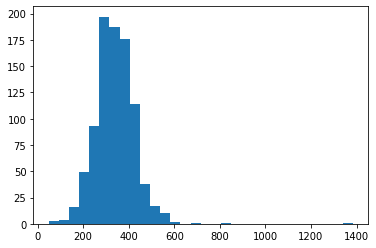

In [4]:
getStats(folder_name,num_notes_dict)

In [ ]:
'''# Analysing trends with respect to noise functions-Plot Mean Rank
import pandas as pd
import matplotlib.pyplot as plt


metric="Mean Rank"
noise="Pitch Change"
output_dir="Results/OverallNoisyResults"
#result_folders=["Results/NoisyResults/1_2_3","Results/NoisyResults/5_6_8"]



result_folders=[f"Results/NoisyResults/{query_dir}" for query_dir in listdir("Results/NoisyResults")]

noise2index={
    "Pitch Change":0,
    "Extra Notes":1,
    "Delete Notes":2,
}


metric2index={
    "Recall@1":0,
    "Recall@3":1,
    "Recall@5":2,
    "Recall@10":3,
    "Mean Rank":4,
    "Normalised Similarity":5,
    "Margin of Error":6,
    "Average Confidence":7,
    "MRR":8
}

metric_index=metric2index[metric]
noise_index=noise2index[noise]

noise_dict={} # Dict of form (pitch, extranotes, deleted) : metric value

for folder in result_folders:
    noise_values=tuple(folder.split("/")[-1].split("_"))
    try:
        df=pd.read_csv(f"{folder}/analysis.csv")
        metric_value=df.iloc[metric_index]["Value"]
        noise_dict[noise_values]=metric_value
    except:
        print(folder)

# Save Dict as CSV
scores=pd.DataFrame(columns=["Pitch","Extra Notes","Deleted",f"{metric}"])
sorted_dict = {k: v for k, v in sorted(noise_dict.items(), key=lambda item: item[1],reverse=True)}

for noise_values,score in sorted_dict.items():
    pitch, extranotes, deleted=noise_values

    scores.loc[len(scores)] = [pitch, extranotes,deleted,score]

scores.index+=1
scores.index.names = ['Index']



scores.to_csv(f"{output_dir}/CSV/{metric}.csv".replace(" ",""))



# X=list(noise_dict.keys())
# Y=list(noise_dict.values())
# # plt.scatter(noise_value,metric_value,c="r")

# plt.title(f"{metric} vs {noise}", fontsize=12, weight='bold')
# plt.xlabel(f"{noise}(%)", fontsize=12)
# plt.ylabel(f"{metric}", fontsize=12)
# plt.savefig(f"{output_dir}/{metric}VS{noise}.png".replace(" ",""))'''

In [ ]:
from typing import Dict

from numpy import sort
from Clarinet.search import similarity
from Clarinet.evaluation import analyse
from os import listdir,path
import json
from tqdm import tqdm
import miditoolkit
from multiprocessing.dummy import Pool as ThreadPool 


from Clarinet.utils.fast import fast

num_processes=4

def evaluate(query_dir,collection_dir,num_queries=-1,num_collection=-1,stride_length=0,similarity_type="text",output_dir="Results",disable=False):
    # print("Reading queries....")
    queries=textFolderToDict(query_dir,num_queries) 
    query_filenames=list(queries.keys())

    # print("Reading collection....")
    collection=textFolderToDict(collection_dir,num_collection)
    collection_filenames=list(collection.keys())

    scores={} # Dict of form {query_num : {collection_num : sim}}
    # print("Computing Similarities..")

    inputs=[]
    
    for i in tqdm(range(len(query_filenames)),disable=disable):
        query_filename=query_filenames[i]
        query_text=queries[query_filename]

        query_scores=queryScores(collection_filenames,collection,query_text,stride_length,similarity_type)

        scores[i]=query_scores

    with open(f"{output_dir}/scores.json", 'w') as fp:
        json.dump(scores, fp)

    with open(f"{output_dir}/querymap.json", 'w') as fp:
        querymap={i:query_filenames[i] for i in range(len(query_filenames))} 
        json.dump(querymap, fp)
    
    with open(f"{output_dir}/collectionmap.json", 'w') as fp:
        collectionmap={i:collection_filenames[i] for i in range(len(collection_filenames))} 
        json.dump(collectionmap, fp)

    # Evaluation Complete, now generate Analysis
    out=list(analyse(f"{output_dir}"))

    best_scores="\n".join(out[0])
    df=out[1]
    df.to_csv(f"{output_dir}/analysis.csv")

    with open(f"{output_dir}/bestscores.txt","w") as f:
        f.write(best_scores)

def textFolderToDict(folder:str,num_files:int)->Dict: # Returns a dict of form {filelocation:text_representation}
    file_locations=sort([f"{folder}/{filename}" for filename in listdir(folder)])
    output_dict={}
    if num_files==-1:
        for file in file_locations:
            if file.endswith(".txt"):
                with open(file,"r") as f:
                    output_dict[file]=f.readlines()[0]
        return(output_dict)
    else:
        for file in file_locations[:num_files]:
            if file.endswith(".txt"):
                with open(file,"r") as f:
                    output_dict[file]=f.readlines()[0]
        return(output_dict)

def queryScores(collection_filenames,collection,query_text,stride_length,similarity_type):
    query_scores={} # Dict of form {collection_num : sim}
    for j in range(len(collection_filenames)):
        collection_filename=collection_filenames[j]
        collection_text=collection[collection_filename]

        sim=similarity(query_text,collection_text,stride_length=stride_length,similarity_type=similarity_type) # Compute similarity

        query_scores[j]=sim
    return(query_scores)